## Import libraries

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns
import torch.nn.functional as F

## Download and Preprocess Dataset

In [10]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

num_classes = 10

## Preprocessing

In [11]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

## Prepare the data

In [55]:
# function for adding some more data from other classes
def put_extra_data(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    for i in range(num_classes):
        if class_num != i:
            # get the indices where label == i
            temp_indices = np.asarray(np.where(source_dataset_labels == i))
            temp_indices = temp_indices.flatten()
            temp_indices = temp_indices[0:50]
            extra_images = source_dataset_images[temp_indices] # get some more negative images
            target_dataset = np.concatenate((target_dataset,extra_images))
    
    return target_dataset

def generate_labels(dataset_images,images_type):
  labels = np.zeros((dataset_images.shape[0],2))
  # for i,image in enumerate(dataset_images):
  #   labels[i][images_type] = np.sum(dataset_images[i]) / 784
  labels = np.full(shape=(dataset_images.shape[0],2),fill_value=[1-images_type,images_type],dtype=np.float32)
  return labels

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels which are the sum of pixel values
    print(dataset_images_positive.shape)
    # get the images for making negative dataset
    dataset_images_negative = invert(dataset_images_positive) # inverted images
    # dataset_images_negative = np.empty((0,28,28),dtype=np.float32)
    dataset_images_negative = put_extra_data(dataset_images,dataset_labels,dataset_images_negative,class_num)
    print(dataset_images_negative.shape)

    # negative_data_indices = [i for i in range(len(dataset_labels)) if i not in indices]
    # dataset_images_negative = dataset_images[negative_data_indices]
    
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

def concat_datasets(dataset1_images,dataset1_labels,dataset2_images,dataset2_labels,class_num):
    # join the two datasets
    joined_dataset_images = np.concatenate((dataset1_images,dataset2_images))
    joined_dataset_labels = np.concatenate((dataset1_labels,dataset2_labels))
    
    indices = np.asarray(np.where(joined_dataset_labels == class_num)) # indices of occurrence of class as label
    indices = indices.flatten()
    dataset_images_positive = joined_dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0)
    negative_data_indices = [i for i in range(len(joined_dataset_labels)) if i not in indices]
    
    dataset_images_negative = joined_dataset_images[negative_data_indices]
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

### Prepare the training set

In [56]:
class_num = 6
batch_size = 64
train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=batch_size,shuffle=True) # take original testing set of all classes

(5918, 28, 28)
(6368, 28, 28)


### Plotting some data

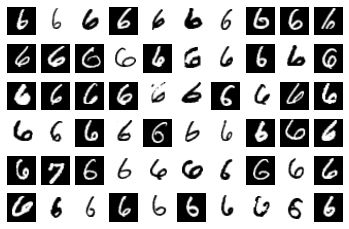

In [57]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
figure = plt.figure()
# print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [1]:
# Model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,100)
        # torch.nn.init.uniform_(self.fc1.weight.data)
        self.fc2 = nn.Linear(100,10)
        # torch.nn.init.uniform_(self.fc2.weight.data)
        self.fc3 = nn.Linear(10,2)
        # torch.nn.init.uniform_(self.fc3.weight.data)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(dim=1)
        return x

epochs = 5
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
# function to train the model
# loss_vals = []
model.train()
for e in range(epochs):
  # epoch_loss = []
  running_loss = 0.0
  for batch, (images,logits) in enumerate(train_loader):
    optimizer.zero_grad()
    # compute prediction error
    output = model(images)
    # print(output)
    # break
    loss = criterion(output,logits)
    # loss = torch.sum(criterion(output,logits),dim=1)
    # print(loss.item())
    # break
    # Backpropagation
    loss.backward()
    optimizer.step()
    # epoch_loss.append(loss.item())
    running_loss += loss.item()
  else:
    print(f"Training loss: {running_loss/len(train_loader)}")
  # plt.plot(epoch_loss)
  # break
  

NameError: ignored

In [53]:
# function to test without threshold
def test(dataloader,model):
  size = len(dataloader.dataset)
  model.eval()
  correct = 0
  with torch.no_grad():
    for images,scores in dataloader:
      output = model(images)
      # print(output)
      correct += (output.argmax(1) == scores.argmax(1)).type(torch.float).sum().item()
  correct /= size
  print(f"Accuracy : {(100*correct):>0.1f}%")

## Testing

In [54]:
# for class_num in range(num_classes):
#     train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
#     test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
#     train_loader = DataLoader(train_class_set,batch_size=64,shuffle=True)
#     test_loader = DataLoader(test_class_set,batch_size=64,shuffle=True) # take original testing set of all classes
    
#     model = NeuralNetwork()

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(),lr = 1e-3,momentum=0.9)
#     print(f"Class Number: {class_num}")
#     train(train_loader,model,criterion,optimizer)
#     y_pred_train = test(train_loader,model)
#     y_pred_test = test(test_loader,model)
# lb = LabelBinarizer()
# lb.fit([0,1])
# binarized_labels = lb.transform(y_pred_test)
# binarized_labels = np.hstack((binarized_labels,1-binarized_labels))
# print(binarized_labels)



# function to test the model on a given threshold
def test_with_threshold(dataloader,model,threshold):
  size = len(dataloader.dataset)
  model.eval()
  accuracy = 0
  y_true = [] # store the true class
  y_pred = [] # store the predicted class
  y_pred_score = []
  y_true_score = []
  with torch.no_grad():
      for images,logits in dataloader:
        output = model(images)
        outnp = output.numpy()
        logit_np = logits.numpy()
        for i in range(len(outnp)):
          true_label = 1 if logit_np[i][0] > logit_np[i][1] else 0 # true class
          y_true.append(true_label)
          y_true_score.append(logit_np[i][0]) # true yes score
          y_pred_score.append(outnp[i][0]) # predicted yes score
          if outnp[i][0] >= threshold:
            y_pred.append(1) # predicted positive class
          else:
            y_pred.append(0) # predicted negative class
  accuracy = accuracy_score(y_true,y_pred) # calculate the accuracy
  precision = precision_score(y_true,y_pred) # calculate precision
  recall = recall_score(y_true,y_pred) # calculate recall

test(test_loader,model)


  # tp = 0.0
  # fp = 0.0
  # tn = 0.0
  # fn = 0.0
  # for i in range(len(y_true)):
  #   if y_true[i] == 1 and y_pred[i] == 1:
  #     tp += 1
  #   elif y_true[i] == 0 and y_pred[i] == 1:
  #     fp += 1
  #   elif y_true[i] == 1 and y_pred[i] == 0:
  #     fn += 1
  #   else:
  #     tn += 1
  # if tp == 0 and fp == 0:
  #   print(threshold)
  # precision = tp / (tp + fp)
  # np.savetxt("y_pred_score.txt",y_pred_score,delimiter=",")
  # np.savetxt("y_true_score.txt",y_true_score,delimiter=",")
  # print(tp,fp,tn,fn,sep=" ")
  # print(f"Accuracy : {(100*correct):>0.1f}%")
  # return (accuracy,precision,recall)

# scores = np.empty((0,3),dtype=np.float32)
# data = np.empty((0,4),dtype=np.float32)

# yes_scores = np.linspace(0.0,3.0,31,endpoint=True)
# print(yes_scores)
# for threshold in yes_scores:
#   accuracy,precision,recall = test(test_loader,model,threshold)
#   data = np.vstack((data,[[threshold,accuracy,precision,recall]]))
#   break

# data
# y = [3]
# np.savetxt("y_pred_score",y,delimiter=",")
  # np.savetxt("y_true_score",y,delimiter=",")
# df = pd.DataFrame(data)
# df.columns = ['threshold','accuracy','precision','recall']
# df
# with torch.no_grad():
#     for images,logits in test_loader:
#       output = model(images)
#       output = output.numpy()
#       logits = logits.numpy()
#       for i in range(len(output)):
#         yes_score = output[i][0]
#         no_score = output[i][1]
#         # print(no_score)
#         true_label =  1 if np.argmax(logits[i]) == 0 else 0 
#         # if true_label == 0:
#         scores = np.vstack((scores,[[yes_score,no_score,true_label]]))
#       # break
# # print(scores)

# df = pd.DataFrame(scores)
# df.columns = ['yes_score','no_score','true_label']
# df

Accuracy : 9.8%


### Plotting the probability scores

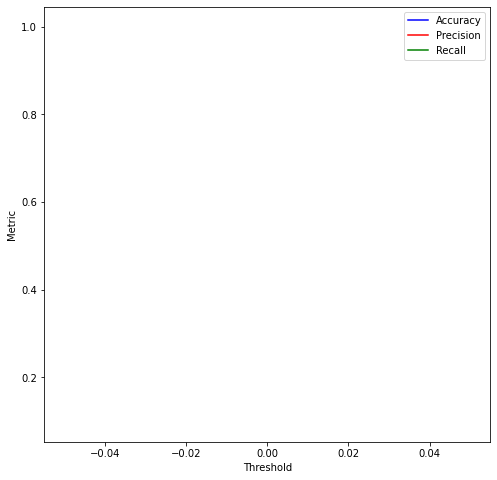

In [ ]:

# print(df.describe())
# sns.FacetGrid(df,hue="true_label",height=7).map(plt.scatter,"yes_score","no_score",alpha=1).add_legend()
plt.figure(figsize=(8,8))
plt.plot(data[:,0],data[:,1],c='b',label='Accuracy')
plt.plot(data[:,0],data[:,2],c='r',label='Precision')
plt.plot(data[:,0],data[:,3],c='g',label='Recall')
plt.legend()
plt.ylabel("Metric")
plt.xlabel("Threshold")
plt.show()

In [ ]:
# plt.scatter(np.log(scores[:,0]),np.log(scores[:,1]))